In [10]:
import numpy as np
import wandb
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [11]:
device = torch.device("cuda:0")
torch.cuda.empty_cache()

In [12]:
class VAE(nn.Module):

    def __init__(self):
        
        super(VAE, self).__init__()
        
        self.z = 10
        self.h = 64*11*11

        self.conv1 = nn.Conv2d(1,32,kernel_size=3)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3)
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(self.h,2*self.z)
        self.fc2 = nn.Linear(self.z,self.h)
        
        self.tconv1 = nn.ConvTranspose2d(64,32,kernel_size=3)  
        self.tconv2 = nn.ConvTranspose2d(32, 1,kernel_size=3)
        self.upsamp = nn.Upsample(scale_factor = 2, mode='nearest')
        
        self.optimizer = optim.Adam(self.parameters(),lr = 0.001)

    def forward(self, x):

        x, mu, logvar = self.encode(x)
        x = self.decode(x)

        return x, mu, logvar
    
    def flatten(self, x):
        
        return x.view(x.size(0),-1)
    
    def unflatten(self,x):

        return x.view(x.size(0),64,11,11)

    def encode(self,x):

        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.flatten(x)
        mu, logvar = torch.chunk(self.fc1(x),2,1)
        z = self.reparameterize(mu,logvar)
        return z, mu, logvar

    def reparameterize(self, mu, logvar):
        
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def decode(self,x):

        x = torch.relu(self.fc2(x))
        x = self.unflatten(x)
        x = torch.relu(self.tconv1(x))
        x = self.upsamp(x)
        x = torch.sigmoid(self.tconv2(x))

        return x

In [13]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001

In [14]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)


In [15]:
def reconstruction_loss(recon_x,x):
    
    r_loss = F.binary_cross_entropy(recon_x,x)
    return r_loss

def kl_loss(mu,logvar):
    
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_loss

In [16]:
vae = VAE().to(device)
wandb.watch(vae, log_freq=100)

In [18]:
for epoch in range(20):
    print("epoch number ", epoch)
    train_loss = 0
    val_loss = 0
    for idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        recon_images, mu, logvar = vae(images)
        r_loss = reconstruction_loss(recon_images, images)
        k_loss = kl_loss(mu, logvar)
        loss = r_loss + k_loss
        vae.optimizer.zero_grad()
        loss.backward()
        vae.optimizer.step()
        train_loss += loss.item()
    print("train loss ", train_loss/(len(train_loader)*batch_size_train))
    for idx, (images, _) in enumerate(test_loader):
        images = images.to(device)
        recon_images, mu, logvar = vae(images)
        r_loss = reconstruction_loss(recon_images, images)
        k_loss = kl_loss(mu, logvar)
        loss = r_loss + k_loss
        val_loss += loss.item()
    print("val loss ", val_loss/(len(test_loader)*batch_size_test))

epoch number  0


/home/raj/anaconda3/envs/pyanomaly/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


train loss  -0.44819846202874714
val loss  -0.03728670082092285
epoch number  1
train loss  -0.5985299276390563
val loss  -0.039838536834716796
epoch number  2
train loss  -0.6223542619107375
val loss  -0.040953895568847654
epoch number  3
train loss  -0.635254176949133
val loss  -0.04139940376281738
epoch number  4
train loss  -0.6435804751509034
val loss  -0.04192227058410645
epoch number  5
train loss  -0.649825029917109
val loss  -0.04189362449645996
epoch number  6
train loss  -0.6542836432136706
val loss  -0.04228707618713379
epoch number  7
train loss  -0.6577780154595243
val loss  -0.04270933837890625
epoch number  8
train loss  -0.6602319104076703
val loss  -0.04270132942199707
epoch number  9
train loss  -0.6624307324255961
val loss  -0.04287945404052734
epoch number  10
train loss  -0.6643232077296609
val loss  -0.04272201042175293
epoch number  11
train loss  -0.6656389134779159
val loss  -0.043026296997070314
epoch number  12
train loss  -0.6669902484427129
val loss  -0.04

In [19]:
import matplotlib.pyplot as plt

In [20]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [21]:
example_data = example_data.to(device)
recon_images, mu, logvar = vae(example_data)

In [22]:
r_img = recon_images.detach().cpu().numpy()
example_data=example_data.detach().cpu().numpy()

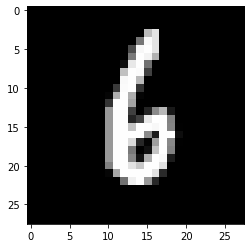

In [23]:
fig = plt.figure()
plt.imshow(example_data[17][0], cmap='gray', interpolation='none')

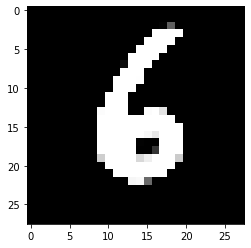

In [24]:
fig = plt.figure()
plt.imshow(r_img[17][0], cmap='gray', interpolation='none')